***
# **Tarea 1 - Análisis de Datos**
***

## **Web scraping, Manejo de datos y Probabilidades**

- **Profesores:** Manuel Pérez (maperezc@inf.udec.cl). Ricardo Flores (rflores@inf.udec.cl).
- **Ayudante:** Jorge Saavedra (jsaavedra2018@udec.cl).

- Fecha de entrega: **26/09/24**

- **¿Cómo?:** La tarea debe ser subida a la plataforma de classroom en un archivo con el formato **NombreApellido_T1.zip**. Este debe contener el código solicitado, junto con el conjunto de datos utilizado.

***
#### **Normas del curso:**
Antes de comenzar lea detenidamente las normas a aplicar en la evaluación de esta tarea.

- El horario límite para entregar la tarea es a las **23:59** de la fecha señalada en el encabezado. Entregas posteriores a la fecha y hora indicada utilizan uno de sus días permitidos para atraso, en caso de no tener días de atraso disponibles se asigna **nota mínima**. Es por esto que se le recomienda subir la tarea con anticipación.
- Cada respuesta debe ser explicada claramente sin dejar espacio a dobles interpretaciones. **El código de la tarea debe estar comentado.**
- Está bien discutir las respuestas con compañeros/as. Está bien buscar la respuesta en internet. Está bien asistir a clases donde comentaremos como resolver la tarea. **No está bien** entregar código escrito por otras personas ya sea compañeros, código obtenido por internet o incluso el código que el profesor programa en clases.
- **Todo código entregado debe ser escrito completamente por usted**. De lo contrario, su tarea será penalizada con la nota mínima.

***

## **$\bullet$ Parte 1: Web scraping (30 ptos)**
El ayudante quiere comenzar su propio canal de criticas y reseñas sobre series de televisión y películas quieren dar una dura pelea a las grandes influencers como CoffeTV, VSXProject, ZEPfilms, etc. Para esto el ayudante ha consumido cuantas series ha podido. Sin embargo, a el también le gustaría tener información actualizada sobre las series disponibles, en todo momento. El ayudante no han tenido tiempo para realizar esto, por lo cual le solicitan ayuda al curso de “Análisis de Datos” del Departamento de Informática de la UdeC para que les ayuden con el script y el análisis.

En base a esto se le solicita a usted que genere un código que permita extraer la información sobre series de television de la página sensacine.com/series-tv filtrados por género, ya que recopila información de varios géneros y paises y no tiene restricciones de extracción de datos mediante técnicas de scraping (más o menos).

### Los datos que les interesan al ayudante son los siguientes:

**Información que se puede extraer desde la página general:**

- Filtrado según género.

**Información que se puede extraer desde la página por género:**

*Identificacion*
- Nombre de la Serie.

*Puntuación*
- Puntuación de los medios.
- Puntuacion de los usuarios.

*Emision:*
- Año de lanzamiento.
- Año de termino.

**Información que deberán extraer dentro de la página de cada serie:**
- Género y subjeneros.
- Cantidad de temporadas.
- Cantidad de episodios.
- Donde se puede ver (servicio de streaming).

Como habrán aprendido en clases, en el proceso de recolección de datos no siempre encontrarán toda la información en cada uno de los productos, por lo cual deberán decidir en cómo trabajar con estos tipos de datos faltantes. Para esto tendrán que explicar cada decisión tomada para la representación de estos. Para efectos de revisión, todos los datos obtenidos deberán ser guardados en un archivo ".pkl" (pickle), ya que la página es actualizada constantemente.

**Resumen:** En esta primera parte se espera que extraigan la información **(15 pts)**, la almacenen en un DataFrame **(2 pts)**, que limpien los datos **(3 pts)**, generen las variables de interes correspondientes en un formato correcto **(7 pts)**, que expliquen las decisiones tomadas **(3 pts)** y guarden los datos en un archivo “.pkl”.

## Librerias

In [2]:
# Puede utilizar más librerias si lo considera necesario------------------------

# Web Scraping------------------------------------------------------------------
import requests
import bs4

# Data handling-----------------------------------------------------------------
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# Computation-------------------------------------------------------------------
import time

# Varios -----------------------------------------------------------------------
import pickle
import random
import os

#-------------------------------------------------------------------------------

In [35]:
#-------------------------------------------------------------------------------
base_url = "https://www.sensacine.com/series-tv/"
#-------------------------------------------------------------------------------
#Variables de interes
Nom_series, Punt_medios, Punt_usuarios, Año_lanzamiento, Año_termino = [], [], [], [], []
Series = {"Nombre":[], "Puntuacion_Usuarios":[], "Puntuacion_Medios":[],"Año_Lanzamiento":[],"Año_Termino":[], "Genero_Principal":[], "Generos_Adicionales":[], "Episodios":[], "Temporadas":[], "Streaming":[]}

#Requests y texto obtenido del url
r = requests.get(base_url)
soup = bs4.BeautifulSoup(r.text,"lxml")
soup_genres_principal = soup.find("ul",attrs={"class":"filter-entity-word"})

#Añadir Generos con sus respectivos codigos para navegar por cada pagina
genres = {"Genre":[], "Code":[]}
for g in soup_genres_principal.select("a"):
    genres['Genre'].append(g.text)
    genres['Code'].append(g['href'].split('/')[2].split("-")[1])
    #<a class="item-content" href="/series-tv/genero-13025/" title="Acción">Acción</a>


## Obteniendo Datos

In [36]:
#For para navegar entre generos
for gen in range(len(genres["Genre"])):
    r = requests.get(url = "https://www.sensacine.com/series-tv/genero-"+ str(genres['Code'][gen]) + "/")
    soup = bs4.BeautifulSoup(r.text,'lxml')
    
    
    pagina = soup.find('div',attrs={'class':'pagination-item-holder'})
    if pagina:
        aux_pagina = pagina.find_all('a', attrs={'class':'button-md'})
        Num_max_pag = [int(a['href'].split('=')[-1]) for a in aux_pagina]
        Max_page = max(Num_max_pag)
    else:
        Max_page = 1

    page_range = range(1, Max_page+1) if Max_page>1 else range (1,2)
    print(f"Categorias : {genres['Genre'][gen]}")
    #Visito cada pagina dentro de un genero
    for i in page_range:

        auxurl = r.url if Max_page==1 else r.url+"?page="+str(i)
        subr = requests.get(auxurl)
        subsoup = bs4.BeautifulSoup(subr.text,'lxml')

        soup_titles = subsoup.find_all('li', attrs={'class':'mdl'}) #Titulo de series/peliculas
        soup_info = subsoup.find_all('div', attrs={'meta-body-item meta-body-info'})
        
        #for para recorrer obtener los datos de la serie sin ingresar (Titulos, Fechas, puntuaciones)
        for y in range(len(soup_titles)): 

            #Quiero acotar que para obtener las puntuaciones Usuarios estaba escrito de 2 formas distintas " Usuarios " y "Usuarios", 
            #para medios decidi asumir que contiene el mismo problema de escritura

            #Añadir los titulos
            aux_title = soup_titles[y].div.a.text
            Series['Nombre'].append(aux_title)
            
            #Añadir puntuacion Usuarios
            if soup_titles[y].find('span',string=' Usuarios '):
                aux = soup_titles[y].find('span',string=' Usuarios ').find_parent().div.span.text
                Series['Puntuacion_Usuarios'].append(aux)

            elif soup_titles[y].find('span',string='Usuarios'):
                 aux = soup_titles[y].find('span',string='Usuarios').find_parent().div.span.text
                 Series['Puntuacion_Usuarios'].append(aux)
            else:
                Series['Puntuacion_Usuarios'].append("-")

            #Añadir puntuacion Medios
            if soup_titles[y].find('span',string=' Medios '):
                aux = soup_titles[y].find('span',string=' Medios ').find_parent().div.span.text
                Series['Puntuacion_Medios'].append(aux)

            elif soup_titles[y].find('span',string='Medios'):
                aux = soup_titles[y].find('span',string='Medios').find_parent().div.span.text
                Series['Puntuacion_Medios'].append(aux)

            else:
                Series['Puntuacion_Medios'].append("-")

            #Obtener fecha de lanzamiento y de termino
            año_aux = soup_info[y].text
            num = re.findall(r'\d{4}',año_aux)
            if len(num) == 1:
                Series['Año_Lanzamiento'].append(num[0])
                Series['Año_Termino'].append("-")

            elif len(num)>1:
                Series['Año_Lanzamiento'].append(num[0])
                Series['Año_Termino'].append(num[1])

            else:
                Series['Año_Termino'].append("-")
                Series['Año_Lanzamiento'].append("-")
        
        #Se ingresa dentro de la serie del indice y
            Codigo_in_serie = soup_titles
            in_serie_url = "https://www.sensacine.com/series/serie-"+str(soup_titles[y].div.h2.a['href'].split("/")[2].split("-")[1])+"/"
            subr_a = requests.get(in_serie_url)
            subsoup_a = bs4.BeautifulSoup(subr_a.text, 'lxml')
            
            if subsoup_a.find('div',attrs={'gd-col-left'}):   #Evitar que la pagina esté caida
                subgen_a = subsoup_a.find('div',attrs={'gd-col-left'}).find('div',attrs={'class':'meta-body-item meta-body-info'}).find_all('span',attrs={'class':'dark-grey-link'}) #Obtener Generos y subgeneros
                subcaps = subsoup_a.find_all('div', attrs={'class':'stats-numbers-row stats-numbers-seriespage'}) #Obtener caps y temporadas recordar que esta clase no existe En todas las series, por ejemplo I, claudius (2011) no existe esa clase, pero si en otras, pasa lo mismo con el streaming
                sub_streams = subsoup_a.find('div',attrs={'gd-col-left'}).find_all("div",attrs={'class':'provider-tile-primary'})
                #Obtencion de Generos y subgeneros
                aux_largo = len(subgen_a) #Largo de generos encontrados 
                largo_generos = range(1, aux_largo) #En caso de haber más de un genero, entonces hay sub generos
                if aux_largo == 0: #Este aux es solo en caso de, muy poco probable, series sin genero
                    Series['Genero_Principal'].append("-")
                    Series['Generos_Adicionales'].append("-")
                elif aux_largo == 1: #Solo 1 genero
                    Series['Genero_Principal'].append(subgen_a[0].text)
                    Series['Generos_Adicionales'].append("-")
                else: #Más de un subgenero    
                    Series['Genero_Principal'].append(subgen_a[0].text)
                    generos_adicionales = ", ".join([subgen_a[z].text for z in range(1, aux_largo)])
                    Series['Generos_Adicionales'].append(generos_adicionales)

                #Obtencion de temporada y capitulos

                if subcaps: #Existe la clase de temporada-capitulo
                    len_tempcap = len(subcaps[0].find_all('div', attrs={'class':'stats-item'}))
                    if len_tempcap==1:    #Existe la clase de Temporadas
                        auxtemp = subcaps[0].find_all('div', attrs={'class':'stats-item'})[0].text.split()[0]
                        Series['Temporadas'].append(auxtemp)
                        Series['Episodios'].append("-")
                    else:     #Existe la clase de episodios y la de temporada, por lo tanto len_tempcap >1
                        auxcap = subcaps[0].find_all('div', attrs={'class':'stats-item'})[1].text.split()[0]
                        auxtemp = subcaps[0].find_all('div', attrs={'class':'stats-item'})[0].text.split()[0]
                        Series['Episodios'].append(auxcap)
                        Series['Temporadas'].append(auxtemp)
                    #else: 
                    #    Series['Episodios'].append("-")
                    #    Series['Temporadas'].append("-")
                else:   #Caso en que no existe la clase, es decir, es probable que sea una pelicula
                    Series['Episodios'].append("-")
                    Series['Temporadas'].append("-")

                #Obtencion de streamings
                if sub_streams:
                    len_stream = len(sub_streams) #Cantidad de opciones de streams de cada serie
                    if len_stream == 0: #No hay plataformas de streaming
                        Series['Streaming'].append("-")
                    else:
                        aux_stream_a = sub_streams
                        aux_stream = ", ".join([aux_stream_a[z].text for z in range(0, len_stream)])
                        Series['Streaming'].append(aux_stream)
                else:
                    Series['Streaming'].append("-")
            else:   #Como la pagina está caida, 
                Series['Genero_Principal'].append(genres['Genre'][gen]) #Como no se puede ingresar a la pagina, asumiremos su genero principal, con el de la categoria en el que se encuentra
                Series['Generos_Adicionales'].append("-")
                Series['Episodios'].append("-")
                Series['Temporadas'].append("-")
                Series['Streaming'].append("-")
                

Categorias : Acción
Categorias : Animación
Categorias : Artes Marciales
Categorias : Aventura
Categorias : Biopic
Categorias : Bollywood
Categorias : Ciencia ficción
Categorias : Comedia
Categorias : Comedia dramática
Categorias : Comedia musical
Categorias : Crimen
Categorias : Dibujos animados
Categorias : Diverso
Categorias : Documental
Categorias : Drama
Categorias : Drama coreano
Categorias : Erótico
Categorias : Espionaje
Categorias : Evento deportivo
Categorias : Familia
Categorias : Fantasía
Categorias : Guerra
Categorias : Histórico
Categorias : Judicial
Categorias : Médico
Categorias : Música
Categorias : Programa
Categorias : Romántico
Categorias : Suspense
Categorias : Telenovela
Categorias : Terror
Categorias : Web Series
Categorias : Western
Categorias : Épico


In [37]:
#Codes de prueba (Para asegurar que no hayan datos faltantes de manera visual cambiando el Indaux)
Indaux = 0

print(f" Nombre: {Series['Nombre'][Indaux]}| Puntuacion: {Series['Puntuacion_Usuarios'][Indaux]} | Año de lanzamiento: {Series['Año_Lanzamiento'][Indaux]} | Año de termino: {Series['Año_Termino'][Indaux]} | Genero principal: {Series['Genero_Principal'][Indaux]} | Generos adicionales: {Series['Generos_Adicionales'][Indaux]} | streaming: {Series['Streaming'][Indaux]} | Temporadas: {Series['Temporadas'][Indaux]}")
print(f" Nombre: {len(Series['Nombre'])}| Puntuacion: {len(Series['Puntuacion_Usuarios'])} | Año de lanzamiento: {len(Series['Año_Lanzamiento'])} | Año de termino: {len(Series['Año_Termino'])} | Genero principal: {len(Series['Genero_Principal'])} | Generos adicionales: {len(Series['Generos_Adicionales'])} | streaming: {len(Series['Streaming'])} | Temporadas: {len(Series['Temporadas'])} | Capitulos: {len(Series['Episodios'])}") 


 Nombre: The Umbrella Academy| Puntuacion: 4,1 | Año de lanzamiento: 2019 | Año de termino: 2024 | Genero principal: Acción | Generos adicionales: Aventura, Fantasía | streaming: Netflix | Temporadas: 4
 Nombre: 4446| Puntuacion: 4446 | Año de lanzamiento: 4446 | Año de termino: 4446 | Genero principal: 4446 | Generos adicionales: 4446 | streaming: 4446 | Temporadas: 4446 | Capitulos: 4446


## Dataframe

In [291]:
#Cometi un error por lo que se vé que Series no esta definido pero si se guardo en un archivo .csv (Cerre vscode)
data = pd.DataFrame(Series)
data

NameError: name 'Series' is not defined

# Convierto el dataset a un archivo .csv

In [290]:
#data en su momento esta definido, pero puesto que cerre vscode, no lo reconoce, pero si lo guarde en un archivo .csv como respaldo.
#Despues leí los requerimientos que pedía que fuesen guardados en .pkl, sin embargo converti el dataset .csv a .pkl
data.to_csv("Datos_Series_Peliculas.csv")

NameError: name 'data' is not defined

## Limpieza

In [200]:
#Verificar si algun dato es nulo, aun cuando durante el webscrapping nos aseguramos de haber trabajado 
data.isnull().sum()
data

,Nombre,Puntuacion_Usuarios,Puntuacion_Medios,Año_Lanzamiento,Año_Termino,Genero_Principal,Generos_Adicionales,Episodios,Temporadas,Streaming
0,The Umbrella Academy,"4,1",-,2019,2024,Acción,"Aventura, Fantasía",36,4,Netflix
1,Perdidos,"4,4",-,2004,2010,Acción,"Aventura, Drama",126,6,Disney+
2,9-1-1,"4,1",-,2018,-,Acción,Drama,99,8,Disney+
3,The Boys,"4,3",-,2019,-,Acción,"Drama, Ciencia ficción",33,5,Amazon Prime Video
4,La Casa de Papel,"4,2",-,2017,2021,Acción,Drama,41,5,Netflix
...,...,...,...,...,...,...,...,...,...,...
4441,Guerra y Paz,"3,2",-,1972,1973,Drama,Épico,20,1,-
4442,La canción del cielo,"3,1",-,2012,-,Drama,"Épico, Romántico, Guerra",2,1,-
4443,"I, Claudius (2011)",-,-,2011,-,Épico,-,-,-,-
4444,Pharaon,-,-,2011,-,Épico,-,-,-,-


In [23]:
#en .pkl
read = pd.read_pickle('Datos_Series_Peliculas.pkl')
read = read.drop_duplicates(subset='Nombre')
read

,Unnamed: 0,Nombre,Puntuacion_Usuarios,Puntuacion_Medios,Año_Lanzamiento,Año_Termino,Genero_Principal,Generos_Adicionales,Episodios,Temporadas,Streaming
0,0,The Umbrella Academy,"4,1",-,2019,2024,Acción,"Aventura, Fantasía",36,4,Netflix
1,1,Perdidos,"4,4",-,2004,2010,Acción,"Aventura, Drama",126,6,Disney+
2,2,9-1-1,"4,1",-,2018,-,Acción,Drama,99,8,Disney+
3,3,The Boys,"4,3",-,2019,-,Acción,"Drama, Ciencia ficción",33,5,Amazon Prime Video
4,4,La Casa de Papel,"4,2",-,2017,2021,Acción,Drama,41,5,Netflix
...,...,...,...,...,...,...,...,...,...,...,...
4440,4440,Toussaint Louverture,-,-,2012,-,Drama,Épico,-,-,-
4441,4441,Guerra y Paz,"3,2",-,1972,1973,Drama,Épico,20,1,-
4443,4443,"I, Claudius (2011)",-,-,2011,-,Épico,-,-,-,-
4444,4444,Pharaon,-,-,2011,-,Épico,-,-,-,-


In [21]:
#Como la tabla está en string, voy a cambiar los datos de string a int, en este caso de Puntuacion_Usuarios, Temporadas, Episodios, año termino, Año_Lanzamiento, Puntuacion_Medios
#Si eventualmente hay datos nulos, se convertiran en 0's
#Y para las puntuaciones reemplazar las comas por puntos para la conversion de los datos a punto flotante 

read['Episodios'] = pd.to_numeric(read['Episodios'], errors='coerce').fillna(0).astype(int)
read['Temporadas'] = pd.to_numeric(read['Temporadas'], errors='coerce').fillna(0).astype(int)
read['Año_Termino'] = pd.to_numeric(read['Año_Termino'], errors='coerce').fillna(0).astype(int)
read['Año_Lanzamiento'] = pd.to_numeric(read['Año_Lanzamiento'], errors='coerce').fillna(0).astype(int)
#Cambiar , por .
read['Puntuacion_Medios'] = read['Puntuacion_Medios'].str.replace(',','.',regex=False)
read['Puntuacion_Medios'] = pd.to_numeric(read['Puntuacion_Medios'], errors='coerce').fillna(0).astype(float)
read['Puntuacion_Usuarios'] = read['Puntuacion_Usuarios'].str.replace(',','.',regex=False)
read['Puntuacion_Usuarios'] = pd.to_numeric(read['Puntuacion_Usuarios'], errors='coerce').fillna(0).astype(float)

read

,Unnamed: 0,Nombre,Puntuacion_Usuarios,Puntuacion_Medios,Año_Lanzamiento,Año_Termino,Genero_Principal,Generos_Adicionales,Episodios,Temporadas,Streaming
0,0,The Umbrella Academy,4.1,0.0,2019,2024,Acción,"Aventura, Fantasía",36,4,Netflix
1,1,Perdidos,4.4,0.0,2004,2010,Acción,"Aventura, Drama",126,6,Disney+
2,2,9-1-1,4.1,0.0,2018,0,Acción,Drama,99,8,Disney+
3,3,The Boys,4.3,0.0,2019,0,Acción,"Drama, Ciencia ficción",33,5,Amazon Prime Video
4,4,La Casa de Papel,4.2,0.0,2017,2021,Acción,Drama,41,5,Netflix
...,...,...,...,...,...,...,...,...,...,...,...
4440,4440,Toussaint Louverture,0.0,0.0,2012,0,Drama,Épico,0,0,-
4441,4441,Guerra y Paz,3.2,0.0,1972,1973,Drama,Épico,20,1,-
4443,4443,"I, Claudius (2011)",0.0,0.0,2011,0,Épico,-,0,0,-
4444,4444,Pharaon,0.0,0.0,2011,0,Épico,-,0,0,-


## **$\bullet$ Parte 2: Manejo de datos (10 ptos)**

En primera al ayudante le gustaría un análisis de filtrado de las series a nivel de generos y año de lanzamiento. Para esto le piden a usted que responda las siguientes preguntas:

### Pregunta 2.1 (2 pts):

* ¿Cuáles servicios de streaming están como opciones disponibles para ver series en la lista de sensacine?
* ¿Cuántas series pueden verse en cada servicio de streaming según la lista de sensacine?

In [5]:
#Pregunta a)
#Puesto que la manera en que gestioné las series de streaming adicionales fue la concatenación, creé un set() que solo almacena datos unicos y fui añadiendo los servicios quitando las ","
Servicios_Streaming = set()
for servicios in read['Streaming']:
    for plataforma in servicios.split(","):
        if plataforma != "-":
            Servicios_Streaming.add(plataforma.strip())
        
print(f"Las series de streaming disponible son: {Servicios_Streaming}")

Las series de streaming disponible son: {'Amazon Prime Video', 'SkyShowtime', 'Netflix', 'Apple TV+', 'Max', 'Disney+'}


In [6]:
#Pregunta b)
#Creo una nueva columna en el que convierto los streaming concatenados en una lista
#Luego añado más filas dependiendo de la cantidad de streamings por serie ocupando explode
#Finalmente cuento cuánto aparece cada serie en cada streaming, como ocupe explode, puede haber una serie repetida 3 veces, pero con 1 streaming distinto, lo que hace que esa serie se contabilice en cada servicio
read['Split_Streams']=0
read['Split_Streams'] = read['Streaming'].str.split(",")
read_exploded = read.explode('Split_Streams')
read_exploded['Split_Streams'] = read_exploded['Split_Streams'].str.strip()
count_a = read_exploded['Split_Streams'].value_counts()
count_a

Split_Streams
-                     1935
Netflix                483
Disney+                261
Amazon Prime Video     220
Max                    142
SkyShowtime             89
Apple TV+               66
Name: count, dtype: int64

### Pregunta 2.2 (2 pts):

¿Como se distribuye la cantidad de géneros en este conjunto de series?

> **Nota**: para el conteo considere repetición de series que contengan más de un género, es decir si una serie tiene 3 generos, esta debe ser contada igualmente en cada categoria.

Para esto se le pide la siguiente tabla:

| Genero | Cantidad |
|:-----------:|:------:|
| Acción  | 38
| Comedia | 286 |
| Drama   | 462 |
| ... | ... |

Ademas, con esta información construya un gráfico de barras. Para esto pueden utilizar la librería **Matplotlib**.

> **Reminder:** Un gráfico siempre debe tener título, labels en el eje x e y, seguir los criterio de Tuffe, etc.

In [7]:
#Pregunta 2.2
#Al igual que la pregunta anterior, añado la columna Generos que tendra los generos principales y los generos adiciones respecto a la serie, 
#luego, se crea la columna generos_split para tener todos los generos de una serie separadas en una lista
#Luego se usa la misma función explode para separar los generos de una serie por filas
#Finalmente se cuentan las series por genero de la columna explotada ("read_exploded_u") 
read['Generos'] = 0
read['Generos_split']=0
read['Generos'] = read['Genero_Principal'] + "," + read['Generos_Adicionales']
read['Generos_split']= read['Generos'].str.split(",")
read_exploded_u = read.explode('Generos_split')
read_exploded_u['Generos_split'] = read_exploded_u['Generos_split'].str.strip()
count = read_exploded_u['Generos_split'].value_counts()
count

Generos_split
Drama                1500
-                     607
Comedia               547
Suspense              422
Animación             360
Acción                326
Fantasía              315
Documental            306
Crimen                295
Aventura              267
Romántico             260
Histórico             245
Familia               240
Ciencia ficción       236
Terror                210
Biopic                209
Telenovela            202
Judicial              198
Comedia dramática     184
Música                139
Médico                 93
Espionaje              91
Guerra                 73
Evento deportivo       71
Western                49
Comedia musical        45
Dibujos animados       33
Drama coreano          28
Artes Marciales        27
Épico                  18
Programa               17
Erótico                14
Web Series              6
Diverso                 2
Bollywood               1
Name: count, dtype: int64

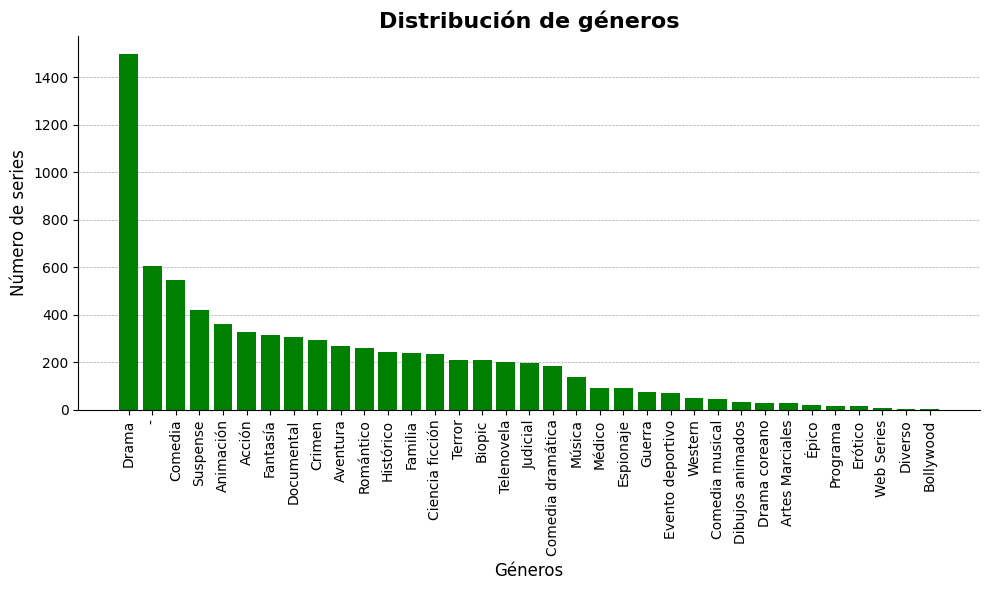

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

#Grafico de barras y titulo
ax.bar(count.index, count.values, color='g', width=0.8,align='center',)
ax.set_title('Distribución de géneros', fontsize=16, weight='bold')

#ejes
ax.set_xlabel('Géneros', fontsize=12)
ax.set_ylabel('Número de series', fontsize=12)

# Rotar las etiquetas del eje X para que no se sobrepongan entre si
plt.xticks(rotation=90)

# Eliminar el borde superior y derecho del gráfico 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Agregar rejilla ligera en el eje Y para facilitar la lectura
ax.yaxis.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

# Ajustar márgenes para que las etiquetas no se corten
plt.tight_layout()
plt.show()

### Pregunta 2.3 (3 pts):


***
### Pregunta 2.3.1
- Entregue una tabla con las 30 series con más de 2 temporadas y mayor puntaje hecho por usuarios. muestre solamente nombre, puntaje, cantidad de temporadas y cantidad de episodios

    *Ejemplo.*

| Nombre | Puntaje de usuarios | Temporadas | Episodios |
|:----------------:|:----------------:|:----------------:|:----------------:|
| Serie 1 |  Score 1 | N1|  Neps1 |
| ... | ... | ... | ... |
| Serie 30 | Score 30 | N30 | Neps30 |

***

In [9]:
#Pregunta 1:  30 series and temporadas>2 and mayor_puntaje por USUARIOS: mostrar -> nombre, puntaje, cantidad de temporadas y cantidad de episodios
#Primero ordeno descendientemente los primero 30
#Luego que las temporadas sean mayor a 2
ordenada_treinta = read.sort_values(by=['Puntuacion_Usuarios'],ascending=False).head(30)
tabla_final_pregunta_uno = ordenada_treinta[(ordenada_treinta.Temporadas>2)]
tabla_final_pregunta_uno[['Nombre','Puntuacion_Usuarios', 'Temporadas', 'Episodios']]

,Nombre,Puntuacion_Usuarios,Temporadas,Episodios
1998,Breaking Bad,4.7,5,62
1975,Juego de Tronos,4.6,8,73
1521,Peaky Blinders,4.5,6,36
450,Vikingos,4.5,6,89
2009,Los Soprano,4.5,6,86
210,Los Simpson,4.5,36,768
1545,Better Call Saul,4.4,6,63
1995,Dexter,4.4,8,96
1996,The Good Doctor,4.4,7,114
1570,Sherlock,4.4,4,14


***
### Pregunta 2.3.2
- Muestre en una tabla el puntaje segun usuarios promedio de todos los generos (redondée a 3 decimales) y luego las estadísticas descriptivas (desviación estándar, promedio, valor máximo y mínimo) de los 3 géneros de series que tengan la mayor puntuación promedio y los 2 generos que tengan la menor puntuación promedio.

    *Ejemplo.*

| Genero   | Puntaje por usuario promedio |xx|
|:--------:|:----------------:|-|
|  Crimen | 3.878 |...|
| ...      | ...       |...|
| Drama coreano | 0.290  |...|

***

In [10]:
#Usando la tabla con los generos explotados en la pregunta anterior:
#agrupo la columna explotada junto a puntuacion_usuarios y generos_splot y obtengo la "media" redondeada a 3 decimales en "promedio_por_genero"
#luego obtengo el top 3 y los ultimos generos de la tabla "promedios_por_genero"
#luego ambas variables las paso a listas para poder trabajarlas y las concateno en la variable series_seleccionadas 
#Luego con la funcion isin obtengo solo los valores (devuelve true) que pertenecen a generos_seleccionados en la tabla read_exploded, donde solo estarán los generos seleccionados
#Finalmente agrupo las series seleccionadas por 'Generos_split' de la columa puntuacion_usuarios y obtengo la desviacion estandar, el promedio, valor maximo y minimo, redondeada a 3 decimas

promedios_por_genero = read_exploded_u.groupby('Generos_split')['Puntuacion_Usuarios'].mean().round(3)
promedios_por_genero.head(30)

top_3 = promedios_por_genero.nlargest(3)
ultimos_2 = promedios_por_genero.nsmallest(2)

generos_seleccionados = top_3.index.tolist() + ultimos_2.index.tolist()
series_seleccionadas = read_exploded_u[read_exploded_u['Generos_split'].isin(generos_seleccionados)]
tabla_final_pregunta_dos=series_seleccionadas.groupby('Generos_split')['Puntuacion_Usuarios'].agg(['std', 'mean', 'max', 'min']).round(10)
tabla_final_pregunta_dos

,std,mean,max,min
Generos_split,,,,
Artes Marciales,1.260963,3.218519,4.4,0.0
Bollywood,NaN,0.000000,0.0,0.0
Ciencia ficción,1.126074,3.200424,4.4,0.0
Diverso,0.000000,0.000000,0.0,0.0
Fantasía,1.158018,3.196190,4.6,0.0


***
### Pregunta 2.3.3
- Entregue una tabla con los servicios de streaming, la cantidad de series que se pueden observar en cada uno de ellos y el puntaje por usuario promedio de estas series, redondée a 3 decimales.

    *Ejemplo.*

| Streaming | Cantidad de series | Puntuacion por usuario promedio |
|:----------------:|:----------------:|:--------------|
|  Netflix | xx |xx|
| ... | ... |...|
| Amazon Prime | xx |xx|

***

In [12]:
#Para esta pregunta obtuve las 2 condiciones de manera separada, es decir usando "read_exploded" de la pregunta 2.1.2 obtuve la cantidad de series por stream
#Luego obtuve el promedio, a traves de groupby y la columna explotada Split_streams
#Despues simplemente las concateno en una dataframe y renombro las columnas
cantidad_series = read_exploded.groupby('Split_Streams').size()
prom_usr_stream = read_exploded.groupby('Split_Streams')['Puntuacion_Usuarios'].mean().round(3)
tabla_streaming = pd.concat([cantidad_series, prom_usr_stream], axis=1)
tabla_streaming.columns = ['Cantidad de Series', 'Promedio de Puntuación']
tabla_streaming

,Cantidad de Series,Promedio de Puntuación
Split_Streams,,
-,1935,2.419
Amazon Prime Video,220,3.383
Apple TV+,66,2.600
Disney+,261,3.164
Max,142,3.559
Netflix,483,2.830
SkyShowtime,89,3.464


### Pregunta 2.4 (3 ptos):

*  Entregue una tabla con series que tengan una puntuacion por usuarios entre mínimo 3.5 y máximo 5.0, que tenga como género Drama, que tengan 2 o más Temporadas, que hayan terminado de emitirse y pueda verse en una plataforma de streaming.


*   ¿Cúal es la plataforma de streaming que vale la pena contratar según calidad/cantidad de series de acuerdo con los datos de Sensacine? Justifique su respuesta.

In [13]:
# Pregunta 3.5< Puntuacion_Usuarios < 5.0, tenga genero drama, temporadas>=2, hayan finalizado y straming>=1, aqui por preferencia decidí ordenarlo de mayor a menor
# para mayor notoriedad
#Filtro las series que tienen en Generos_split cuales tienen almenos Drama (No necesariamente como genero principal)
#Luego como en split streams, los que no tiene plataforma de streaming se consideran como [-] entonces, aplico un filto que no se consideren [-]
#Para las series finalizadas considere que el año de termino simplemente sea mayor a 0
# Para temporadas solo basta temporadas>=2, lo mismo para puntuacion : 3.5< Puntuacion_Usuarios < 5.0
Series_drama = read[read['Generos_split'].apply(lambda x: 'Drama' in x)]
Stream_mayor_cero = Series_drama['Split_Streams'].apply(lambda x: "-" not in x)
pregunta_dos_cuatro_final = Series_drama[ (Series_drama.Puntuacion_Usuarios < 5.0) & (Series_drama.Puntuacion_Usuarios >= 3.5) & (Series_drama.Temporadas>=2) & (Series_drama.Año_Termino > 0) & (Stream_mayor_cero)] 
pregunta_dos_cuatro_final[['Nombre','Puntuacion_Usuarios','Año_Lanzamiento','Año_Termino','Temporadas','Generos','Split_Streams']].sort_values(by=['Puntuacion_Usuarios'],ascending=False)

,Nombre,Puntuacion_Usuarios,Año_Lanzamiento,Año_Termino,Temporadas,Generos,Split_Streams
1975,Juego de Tronos,4.6,2011,2019,8,"Drama,Fantasía",[Max]
1521,Peaky Blinders,4.5,2013,2022,6,"Crimen,Drama, Histórico",[Amazon Prime Video]
2009,Los Soprano,4.5,1999,2007,6,"Drama,-",[Max]
2127,Anne with an E,4.4,2017,2019,3,"Drama,-",[Netflix]
1995,Dexter,4.4,2006,2013,8,"Drama,Suspense",[SkyShowtime]
...,...,...,...,...,...,...,...
1633,¿Quién Mató a Sara?,3.5,2021,2022,3,"Crimen,Drama, Suspense",[Netflix]
1219,High School Musical: El Musical: La serie,3.5,2019,2023,4,"Comedia,Drama, Comedia musical",[Disney+]
2085,Fear The Walking Dead,3.5,2015,2023,8,"Drama,Terror, Suspense",[Amazon Prime Video]
2676,Embrujadas (2018),3.5,2018,2022,4,"Drama,Fantasía, Suspense",[Max]


#   ¿Cúal es la plataforma de streaming que vale la pena contratar según calidad/cantidad de series de acuerdo con los datos de Sensacine? Justifique su respuesta.
# Respuesta
* Primero notemos la proporcion calidad/cantidad

In [14]:
tabla_streaming['Calidad/Cantidad'] = (tabla_streaming['Promedio de Puntuación']/tabla_streaming['Cantidad de Series'])
tabla_streaming

,Cantidad de Series,Promedio de Puntuación,Calidad/Cantidad
Split_Streams,,,
-,1935,2.419,0.001250
Amazon Prime Video,220,3.383,0.015377
Apple TV+,66,2.600,0.039394
Disney+,261,3.164,0.012123
Max,142,3.559,0.025063
Netflix,483,2.830,0.005859
SkyShowtime,89,3.464,0.038921


In [15]:
tabla_streaming.loc[tabla_streaming['Calidad/Cantidad'].idxmax()]

Cantidad de Series        66.000000
Promedio de Puntuación     2.600000
Calidad/Cantidad           0.039394
Name: Apple TV+, dtype: float64


R: Aqui nos damos cuenta que en cuanto a calidad/cantidad la que más vale la pena es "Apple TV+" con una proporción igual a  0.039394

## **$\bullet$ Parte 3: Probabilidades (20 ptos)**

En varios estudios nos interesa conocer o saber cual es la distribución de la que vienen nuestros datos, en otras palabras, estimar cual es el modelo que generó nuestros datos. Una forma de modelar el comportamiento de una variable es utilizando distribuciones paramétricas.

### Pregunta 3.1 (13 pts)

***

* Derive el estimador de maxima verosimilitud para una distribución Normal. Supongamos que tenemos una muestra de tamaño $n$ extraída de una distribución normal con media $\mu$ y desviación estándar $\sigma$. El objetivo es encontrar los estimadores de máxima verosimilitud para $\mu$ y $\sigma$, dada una muestra ($ X_1, X_2, \ldots, X_n $), donde la función de densidad de probabilidad de la distribución normal está dada por:

\begin{equation}
f(x \mid \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(x - \mu)^2}{2 \sigma^2} \right)
\end{equation}

* Compute el estimador de maxima verosimilitud para la columna de datos de "puntaje segun usuarios" y ajuste la distribucion normal a los datos. Genere un gráfico comparando la distribucion real de datos versus el modelo paramétrico.

***

***
## Desarrollo de derivación en imagen dentro del archivo .zip
* En definitiva se obtuvo que mu es igual a la media muestral y sigma igual a la desviación estandar sin corrección de error muestral

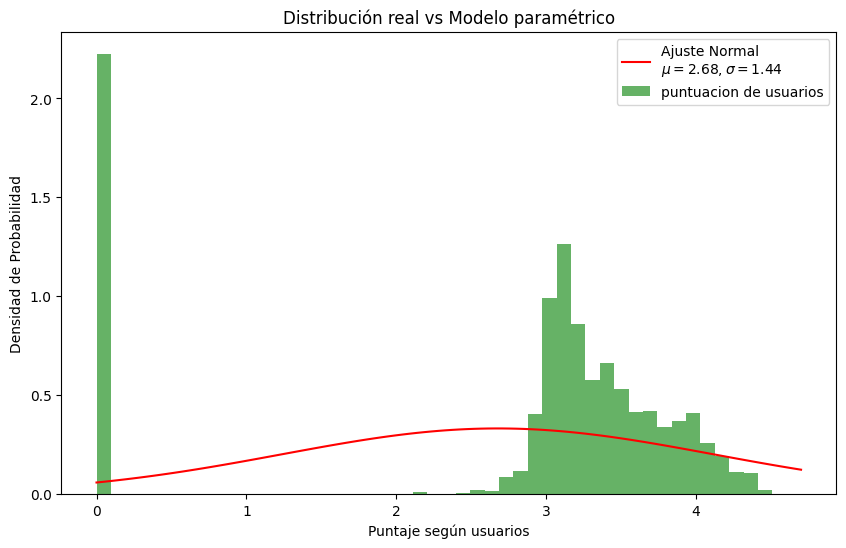

In [16]:
data_usuarios = read['Puntuacion_Usuarios'].to_numpy().flatten()

#Estimadores obtenidos
mu_a = np.mean(data_usuarios)
sigma_a = np.std(data_usuarios, ddof=1)

puntos_x = np.linspace(min(data_usuarios), max(data_usuarios), 100)

def func_normal(x, mu, sigma):
    a = 1/np.sqrt(2*np.pi*sigma)
    exponente = np.exp(-((x-mu)**2)/(2*sigma**2))
    return a*exponente
#ajuste de la funciona de densidad normal
func_den_norm = func_normal(puntos_x, mu_a, sigma_a)
#Comparar por cuartiles Freedman Diaconis para obtener numero de bins
q1 = np.percentile(data_usuarios, 25)
q3 = np.percentile(data_usuarios, 75)
n = len(data_usuarios)
h = 2*(q3-q1)/(n**(1/3))
k = int((np.max(data_usuarios) - np.min(data_usuarios)) / h)
#grafico
plt.figure(figsize=(10, 6))
plt.plot(puntos_x, func_den_norm, 'r-', label=f'Ajuste Normal\n$\mu={mu_a:.2f}, \sigma={sigma_a:.2f}$')
plt.hist(data_usuarios, bins=k, density=True, color='g', alpha=0.6, label='puntuacion de usuarios')
plt.title('Distribución real vs Modelo paramétrico')
plt.xlabel('Puntaje según usuarios')
plt.ylabel('Densidad de Probabilidad')
plt.legend()
plt.show()

### Pregunta 3.2 (7 pts)

***
Calcule las siguientes probabilidades condicionales del puntaje segun usuarios directamente desde los datos (muestreo) y comparelas con la probabilidad arrojada por el modelo paramétrico cuando ingresa los valores condicionados dentro de este mismo.

* $ P(4 \leq Puntuacion\ usuarios \leq 5) $ <p>

* $ P(4 \leq Puntuacion\ usuarios \leq 5 \ | In \ Streaming) $ <p>

* $ P(4 \leq Puntuacion\ usuarios \leq 5 \ | In \ Streaming,\ Temporadas \geq 4) $
***

> **Nota:** In streaming se refiere a que la serie puede encontrarse en una plataforma de streaming.

In [17]:
#Pregunta 1
total_series = len(read)
P_uno = len(read[ (read['Puntuacion_Usuarios'] >=4 ) & (read['Puntuacion_Usuarios']<=5)])
print(f"P(4<= Puntuacion usuarios <= 5): {(P_uno/total_series):.3f}")

#Pregunta 2
Series_con_Streaming = read[read['Streaming'].apply(lambda x: '-' not in x)]
total_series_in_Streaming = len(read[read['Streaming'].apply(lambda x: '-' not in x)])
P_dos = len( Series_con_Streaming[ (Series_con_Streaming['Puntuacion_Usuarios'] >=4 ) & (Series_con_Streaming['Puntuacion_Usuarios'] <= 5)])
print(f"P(4<= Puntuacion usuarios <= 5 | In Streaming): {(P_dos/total_series_in_Streaming):.3f}")

#Pregunta 3
P_tres = len( Series_con_Streaming[ (Series_con_Streaming['Puntuacion_Usuarios'] >=4 ) & (Series_con_Streaming['Puntuacion_Usuarios'] <= 5) & (Series_con_Streaming['Temporadas']>=4)])
print(f"P(4<= Puntuacion usuarios <= 5 | In Streaming, temporadas >= 4): {(P_tres/total_series_in_Streaming):.3f}")



P(4<= Puntuacion usuarios <= 5): 0.106
P(4<= Puntuacion usuarios <= 5 | In Streaming): 0.173
P(4<= Puntuacion usuarios <= 5 | In Streaming, temporadas >= 4): 0.111
